
Książki, które wybrałem do analizy:


*   Mały książe
*   Dziady II
*   Dziady III
*   Ogniem i mieczem I
*   Ogniem i mieczem II
*   Tajemniczy Ogród









In [1]:
from urllib.request import urlopen
import certifi
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from collections import Counter
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
!python3 -m spacy download pl_core_news_lg

In [3]:
nlp = spacy.load("pl_core_news_lg")

In [4]:
def book(url):
    return urlopen(url).read().decode("utf8")

## 1. Utworzyć korpus dokumentów na podstawie 5-10 książek pobranych ze strony wolne lektury

In [5]:
malyKsiaze = book('https://wolnelektury.pl/media/book/txt/saint-exupery-maly-ksiaze.txt')
dziady2 = book('https://wolnelektury.pl/media/book/txt/dziady-dziady-poema-dziady-czesc-ii.txt')
dziady3 = book('https://wolnelektury.pl/media/book/txt/dziady-dziady-poema-dziady-czesc-iii.txt')
ogiemIMieczemT1 = book('https://wolnelektury.pl/media/book/txt/ogniem-i-mieczem-tom-pierwszy.txt')
ogniemIMieczemT2 = book('https://wolnelektury.pl/media/book/txt/ogniem-i-mieczem-tom-drugi.txt')
tajemniczyOgrod = book('https://wolnelektury.pl/media/book/txt/tajemniczy-ogrod.txt')


Dodaję do procesu przetwarzania tokenizację i lematyzację, aby sensowniejsze wyniki otrzymywać w kolejnych krokach i aby łatwiej było wyciągać wnioski na potrzeby komentarzy.

In [6]:
def tokenizer(document):

    return [word.text.lower() for word in nlp(document) if word.text not in 
            '\n\r\t!"-—#$%&()--.*+,-/:;<=>?@[\\]^_`{|}~' and word.text.isalpha()]

In [8]:
def lemmatizer(document):
    return [word.lemma_ for word in nlp(" ".join(document))]

In [10]:
malyKsiaze = lemmatizer(tokenizer(malyKsiaze))
dziady2 = lemmatizer(tokenizer(dziady2))
dziady3 = lemmatizer(tokenizer(dziady3))
ogiemIMieczemT1 = lemmatizer(tokenizer(ogiemIMieczemT1))
ogniemIMieczemT2 = lemmatizer(tokenizer(ogniemIMieczemT2))
tajemniczyOgrod = lemmatizer(tokenizer(tajemniczyOgrod))

## 2. Dla każdej z pozycji zwizualizować częstość występowania tokenów i skomentować zgodność z prawem Zipfa

Prawo Zipfa - słowa, które występują najczęściej to zazwyczaj słowa najmniej znaczące,

Największą wagę w Bag of Words (w wektorze częstotliwości) mają słowa występujące najczęsciej w tekście, ale niosą najmniej informacji, na przykład spójniki (ale, więc itp.) , takie słowa powinny być na stopliście i powinny zostać wycięte z wektora, często również powtarzają się słowa z tytułu, albo jak magazyn jest o samochodach to często pojawi się motyw przewodni - słowo samochód, jednak nie wnosi to zbyt wiele znaczenia przy analizie samych magazynów motoryzacyjnych

Frequency * Rank = const

In [24]:
malyKsiazeWordFrequency = Counter(malyKsiaze) # Counter pozwala zliczyć częstość występowania słów ( poddanych wcześniej tokenizacji i lematyzacji )

print(malyKsiazeWordFrequency.most_common(10))

dziady2WordFrequency = Counter(dziady2)
dziady3WordFrequency = Counter(dziady3)
ogiemIMieczemT1WordFrequency = Counter(ogiemIMieczemT1)
ogniemIMieczemT2WordFrequency = Counter(ogniemIMieczemT2)
tajemniczyOgrodWordFrequency = Counter(tajemniczyOgrod)



[('mały', 194), ('książę', 166), ('powiedzieć', 118), ('być', 109), ('nie', 105), ('to', 95), ('mieć', 85), ('on', 75), ('planeta', 68), ('ja', 66)]


In [25]:
import matplotlib.pyplot as plt
# most_common(x) zastosowane na zmiennej typu Counter zwraca listę krotek (klucz, wartosc), w naszym przypadku (slowo, czestosc)
def show_prawo_Zipfa_plot(list_of_common_words):
  words = [] # dane słowa o danej częstości i rankingu zawartych w poniższych listach
  words_frequency = [] # częstość występowania danego słowa 
  ranks = [] # ranking, gdzie 1 - najpopularniejsze słowo
  rank = 1
  for i in list_of_common_words:
    
    words.append(i[0])
    words_frequency.append(i[1])
    ranks.append(rank)
    rank = rank + 1

  multiply = []
  for i in ranks: 
    multiply.append(i*words_frequency[i-1]) # ranks liczony jest od jedynki, a lista jest indeksowana od 0

  plt.bar(words, words_frequency)
  plt.show()

  print("Wykres prezentujący wartości f * r ")

  plt.bar(words, multiply)
  plt.show()

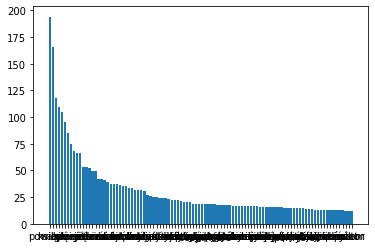

Wykres prezentujący wartości f * r 


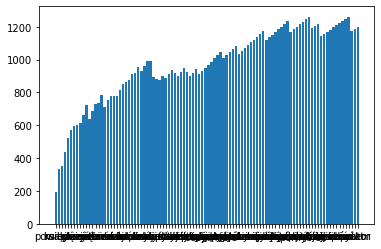

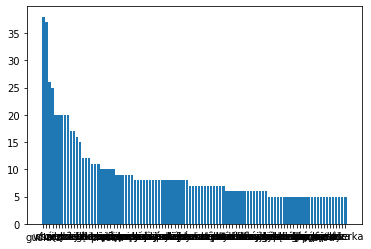

Wykres prezentujący wartości f * r 


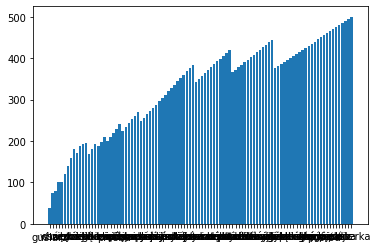

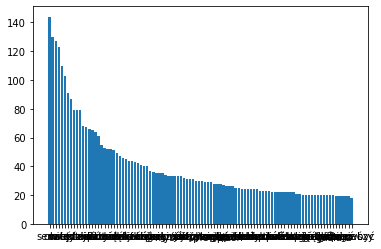

Wykres prezentujący wartości f * r 


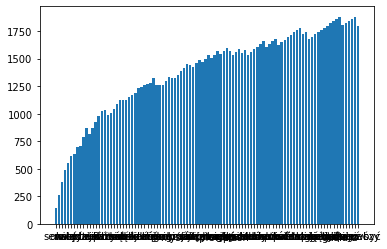

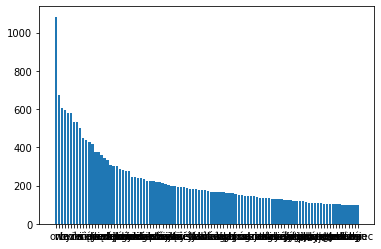

Wykres prezentujący wartości f * r 


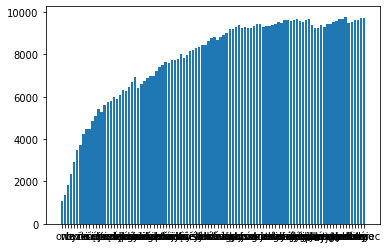

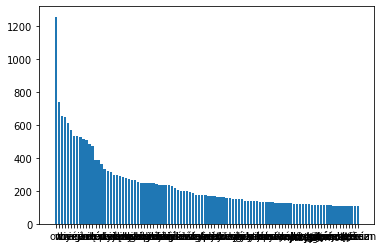

Wykres prezentujący wartości f * r 


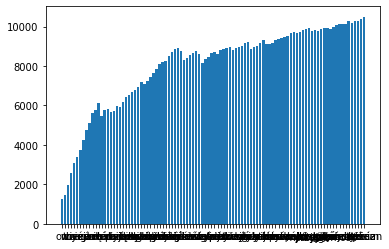

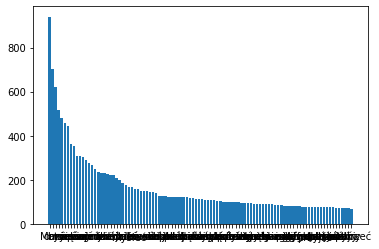

Wykres prezentujący wartości f * r 


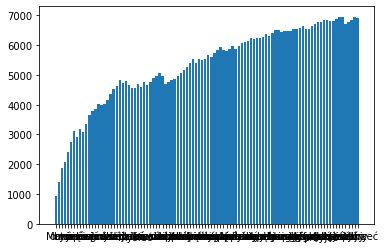

In [26]:
show_prawo_Zipfa_plot(malyKsiazeWordFrequency.most_common(100))
show_prawo_Zipfa_plot(dziady2WordFrequency.most_common(100))
show_prawo_Zipfa_plot(dziady3WordFrequency.most_common(100))
show_prawo_Zipfa_plot(ogiemIMieczemT1WordFrequency.most_common(100))
show_prawo_Zipfa_plot(ogniemIMieczemT2WordFrequency.most_common(100))
show_prawo_Zipfa_plot(tajemniczyOgrodWordFrequency.most_common(100))

Zgodnie z prawem Zipfa, słowa, które obserwujemy najczęściej to słowa takie jak: "i", "on", "się", są to słowa, które nie wnoszą żadnej wartości do analizy tekstu, zatem wykazana została zgodność z prawem Zipfa. Słowa tego rodzaju zostaną usunięte za pomocą stoplisty.

## 3. Zastosować stoplistę dla języka polskiego

In [27]:
def removeStopwords(document):
    stopwords = tokenizer(urlopen('https://raw.githubusercontent.com/bieli/stopwords/master/polish.stopwords.txt').read().decode("utf8"))

    for word in document:
        if word in stopwords:
            document.remove(word)

    return document

In [28]:
malyKsiaze = removeStopwords(malyKsiaze)
dziady2 = removeStopwords(dziady2)
dziady3 = removeStopwords(dziady3)
ogiemIMieczemT1 = removeStopwords(ogiemIMieczemT1)
ogniemIMieczemT2 = removeStopwords(ogniemIMieczemT2)
tajemniczyOgrod = removeStopwords(tajemniczyOgrod)


In [29]:
# częstość po usunięciu słów ze stoplisty

malyKsiazeWordFrequency = Counter(malyKsiaze)
#print(malyKsiazeWordFrequency)
dziady2WordFrequency = Counter(dziady2)
#print(dziady2WordFrequency)
dziady3WordFrequency = Counter(dziady3)
#print(dziady3WordFrequency)
ogiemIMieczemT1WordFrequency = Counter(ogiemIMieczemT1)
#print(ogiemIMieczemT1WordFrequency)
ogniemIMieczemT2WordFrequency = Counter(ogniemIMieczemT2)
#print(ogniemIMieczemT2WordFrequency)
tajemniczyOgrodWordFrequency = Counter(tajemniczyOgrod)
#print(tajemniczyOgrodWordFrequency)

## 4. Na podstawie korpusu zbudowanego z 5 dowolnych książek (postanowiłem wybrać wszystkie 6) zbudować macierz TF-IDF

In [30]:
corpus = []
corpus.append(" ".join(malyKsiaze))
corpus.append(" ".join(dziady2))
corpus.append(" ".join(dziady3))
corpus.append(" ".join(ogiemIMieczemT1))
corpus.append(" ".join(ogniemIMieczemT2))
corpus.append(" ".join(tajemniczyOgrod))


Macierz TF-IDF: Częstość występowania słowa w dokumencie, ale skorygowana częstością występowania w całym korpusie dokumentów
Mniej ważne słowa - mniejsza waga - słowa, które są w każdym dokumencie

In [31]:
tfidf  =TfidfVectorizer(smooth_idf=False)
tfs = tfidf.fit_transform(corpus) 
tfs.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.00070889, 0.        , 0.00094303, ..., 0.        , 0.00283558,
         0.00094303],
        [0.00199284, 0.        , 0.        , ..., 0.00066428, 0.00265712,
         0.        ],
        [0.        , 0.00097679, 0.        , ..., 0.00073427, 0.        ,
         0.        ]])

## 5. W oparciu o podobieństwo cosinusowe zbudować macierz odległości dokumentów

**Notatki:**  macierz podobieństwa cosinusowego jest rozmiaru: liczba dokumentów x liczba dokumentów, przecięcia oznaczają podobieństwo tych dokumentów do siebie

In [32]:
counts = CountVectorizer().fit_transform(corpus) 
print(cosine_similarity(counts))
cosineSimilarity = pd.DataFrame(np.matrix(cosine_similarity(counts)))
cosineSimilarity.columns=["malyKsiaze","dziady2","dziady3","ogiemIMieczemT1","ogiemIMieczemT2","tajemniczyOgrod"]
cosineSimilarity.index = ["malyKsiaze","dziady2","dziady3","ogiemIMieczemT1","ogiemIMieczemT2","tajemniczyOgrod"]
cosineSimilarity

[[1.         0.36969376 0.5694389  0.54895821 0.56574919 0.59159139]
 [0.36969376 1.         0.49902928 0.38361775 0.38356266 0.36984778]
 [0.5694389  0.49902928 1.         0.63723679 0.64209742 0.6039394 ]
 [0.54895821 0.38361775 0.63723679 1.         0.92671175 0.63901867]
 [0.56574919 0.38356266 0.64209742 0.92671175 1.         0.6490669 ]
 [0.59159139 0.36984778 0.6039394  0.63901867 0.6490669  1.        ]]


,malyKsiaze,dziady2,dziady3,ogiemIMieczemT1,ogiemIMieczemT2,tajemniczyOgrod
malyKsiaze,1.000000,0.369694,0.569439,0.548958,0.565749,0.591591
dziady2,0.369694,1.000000,0.499029,0.383618,0.383563,0.369848
dziady3,0.569439,0.499029,1.000000,0.637237,0.642097,0.603939
ogiemIMieczemT1,0.548958,0.383618,0.637237,1.000000,0.926712,0.639019
ogiemIMieczemT2,0.565749,0.383563,0.642097,0.926712,1.000000,0.649067
tajemniczyOgrod,0.591591,0.369848,0.603939,0.639019,0.649067,1.000000


## 6. Przeprowadzić redukcję wymiarowości wymiarów macierzy TF-IDF do 2 wymiarów i zwizualizować położenie dokumentów na układzie współrzędnych

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


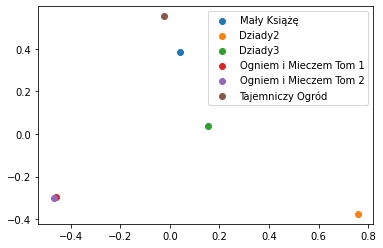

In [33]:
books = {0: 'Mały Książę', 1: 'Dziady2', 2: 'Dziady3', 3: 'Ogniem i Mieczem Tom 1', 4: 'Ogniem i Mieczem Tom 2', 5: 'Tajemniczy Ogród'}
books_pca = PCA(n_components=2).fit_transform(tfs.todense())
fig, ax = plt.subplots()

for i,null in enumerate(books_pca):
    
    pcaCoord1, pcaCoord2 = books_pca[i]
    book = books[i]
    ax.scatter(pcaCoord1, pcaCoord2, label=book)
    
plt.legend();
plt.show();

## 7. Skomentować spójność wyników z punktu 4 i 5

Komentarz: im kropeczki bliżej siebie tym podobieństwo książek, które reprezentują te kropki jest większe. Zasadniczo dwie książki będące kolejnymi częsciami trylogii wykazują duże podobieństwo co zaobserwowano dla "Ogniem i Mieczem Tom1" oraz "Ogniem i Mieczem Tom2".
W przypadku tabeli prezentującej podobieństwo cosinusowe, im większa liczba na przecięciu, tym większe podobieństwo książek do siebie, dlatego w tabeli prezentującej wyniki można zaobserwować jedynki na przecięciu się ze sobą tego samego tytułu. Z tabeli prezentującej podobieństwo cosinusowe można wywnioskować, że Tajemniczy ogród wykazuje spore podobieństwo do Ogniem i Mieczem I oraz II, niekoniecznie widać to akurat na wykresie po redukcji wymiarów. Ciekawym dla mnie wynikiem jest fakt, że obie analizowane części Dziadów nie wykazują aż tak dużego podobieństwa do siebie.